## A. Download data 

## B. Load libraries

In [1]:
# Importing the numpy library with the alias 'np' for numerical computations
import numpy as np

# Importing the sys module for system-specific parameters and functions
import sys

# Importing the xarray library with the alias 'xr' for labeled data analysis
import xarray as xr

# Importing the deepcopy function from the copy module for creating deep copies of objects
from copy import deepcopy

# Importing the pyplot module from the matplotlib library for creating data visualizations
import matplotlib.pyplot as plt

# Activating inline plotting in Jupyter Notebook for displaying plots within the notebook itself
%matplotlib inline

# Importing the glob module for file path expansion and searching
import glob

# Importing the warnings module for handling warnings during code execution
import warnings

# Import os to acess USB driver
import os

# Ignoring all warnings that may occur during the execution of the code
# warnings.filterwarnings('ignore')

In [2]:
## Import the ecco_v4_py library into Python
# Importing specific functions from the os.path module for path manipulations
from os.path import join, expanduser

# Defining the variable 'user_home_dir' to store the path to the user's home directory
user_home_dir = expanduser('~')

# Appending the path to the ECCOv4-py library to the list of directories where Python looks for modules
sys.path.append(join(user_home_dir, 'ECCOv4-py'))

# Importing the ecco_v4_py library and aliasing it as 'ecco' for ease of use
import ecco_v4_py as ecco

## B. Load model grid

In [3]:
## Set top-level file directory for the ECCO NetCDF files

# Specify the path to your USB drive
usb_drive_path = "/Volumes/Liliana"  # Use the actual name of your USB drive

# Define the ECCO_dir using the join function with the USB drive path
ECCO_dir = os.path.join(usb_drive_path, 'ECCO_V4r4_PODAAC')

# ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [4]:
# glob.glob is finding files that match a certain pattern in the specified directory (ECCO_dir)
# join is joining the file path and the pattern to search for the files
# The [0] at the end is selecting the first file from the list of found files
# xr.open_dataset is opening the selected file as an xarray dataset, assigning it to the variable ecco_grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [5]:
## Create a list of the files using glob
# this line finds and stores a list of file paths matching the pattern '*SSH*MONTHLY*' in the directory specified by ECCO_dir.
SSH_monthly_files = glob.glob(join(ECCO_dir,'*SSH*LLC0090GRID_MONTHLY*','*.nc'))

## This is a function that loads and concatenates multiple files into a single dataset while dropping specified variables.
# loads each file into memory using open_dataset
def ds_load_concat(file_list, dim_concat, vars_to_drop):
    for count, file in enumerate(file_list):
        if count == 0:
            ds_out = xr.open_dataset(file)
            ds_out = ds_out.drop_vars(vars_to_drop)
            # For the first file, it opens it as a dataset and drops specified variables.
        else:
            ds_curr = xr.open_dataset(file)
            # For subsequent files, it opens them as datasets, drops specified variables, and concatenates them.
            ds_curr = ds_curr.drop_vars(vars_to_drop)
            ds_out = xr.concat((ds_out, ds_curr), dim=dim_concat)
    return ds_out

# This line uses the function to create a new dataset 'ds_SSH_monthly' by loading, concatenating, and cleaning the SSH_monthly_files.
ds_SSH_monthly = ds_load_concat(SSH_monthly_files, dim_concat='time', vars_to_drop=['SSHNOIBC', 'SSHIBC', 'ETAN'])

# This line merges two datasets 'ecco_grid' and 'ds_SSH_monthly' into a single dataset 'ecco_monthly_ds'.
ecco_monthly_ds = xr.merge((ecco_grid, ds_SSH_monthly))

In [6]:
ecco_monthly_ds = ecco_monthly_ds.sortby('time')
print(ecco_monthly_ds.time[0].values)
print(ecco_monthly_ds.time[-1].values)

1992-01-16T18:00:00.000000000
2017-12-16T06:00:00.000000000


## Total ocean surface area

In [7]:
# Computing ocean mask based on wetness of grid cells
# Using the 'ceiling' function to convert non-zero values to 1
# and leaving 0 values unchanged, indicating dry cells
ocean_mask = np.ceil(ecco_monthly_ds.hFacC)

# Replacing non-one values in the ocean mask with NaN
# This ensures that dry cells are represented as NaN in the mask
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

<Figure size 1080x450 with 0 Axes>

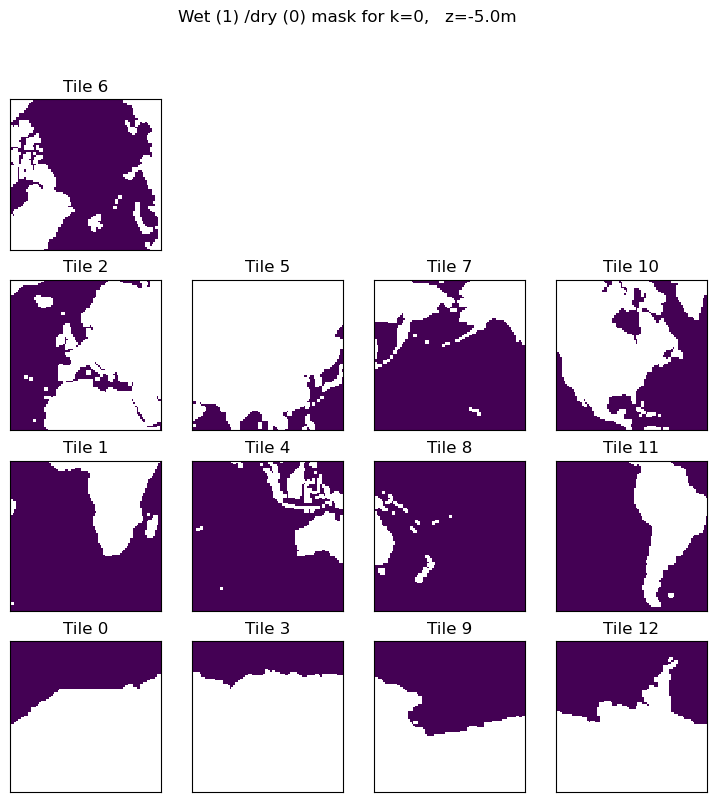

In [8]:
# Set the size and quality of the plot figure
plt.figure(figsize=(12,5), dpi=90)

# Plot the tiles of the ocean mask at vertical level k=0
# 'isel' method - "integer selection - used to select data based on the integer index
ecco.plot_tiles(ocean_mask.isel(k=0), layout='latlon', rotate_to_latlon=True)

# Select and round the model depth at k=0, then convert it to a string
z = str((np.round(ecco_monthly_ds.Z.values[0])))

# Set the super title of the plot with information about wet and dry areas at k=0
plt.suptitle('Wet (1) /dry (0) mask for k=' + str(0) + ',   z=' + z + 'm');

In [9]:
# Select the land_c variable at index 0 in the 'k' dimension
# This selects the first layer of the ocean mask for calculation
# rA is the area of tracer grid cell
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask[0,:])

# Print the total ocean surface area in square kilometers
# Convert the printed value to scientific notation with 2 decimal places
print('total ocean surface area (km^2) %.2E' % (total_ocean_area.values/1.0e6))

total ocean surface area (km^2) 3.58E+08


## DSSHA 

Dynamic sea surface height anomaly (DSSHA) is a measure of the deviation of the actual sea surface height from the geoid. It represents the temporal variations in the ocean's surface height caused by factors such as ocean currents, tides, winds, and other dynamic processes. DSSHA is an important parameter for studying ocean dynamics and is used in various oceanographic and climate studies to understand the changes in sea level due to these dynamic processes. It provides insights into ocean circulation patterns and the interaction between the ocean and the atmosphere.

The geoid is the shape that the surface of the oceans would take under the influence of Earth's gravitational field alone, if other influences such as winds and tides were absent. In simpler terms, it can be considered as the shape that the ocean surface would have if it were extended through the continents, and it serves as a reference surface for measuring elevations and depths on Earth. 

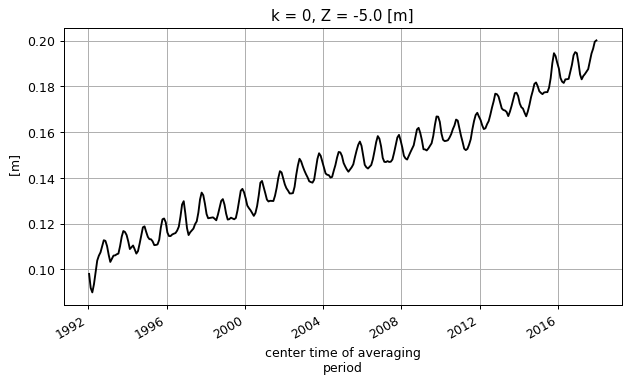

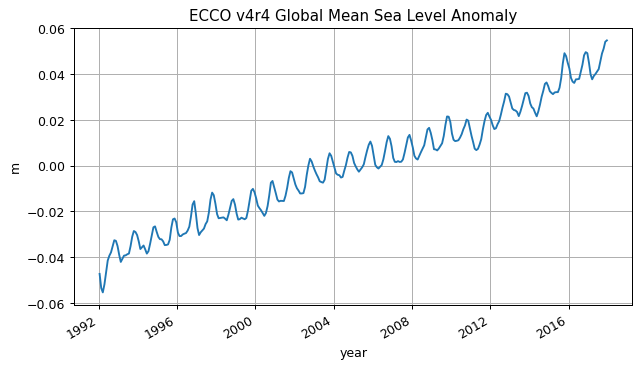

In [10]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean_mon = (ecco_monthly_ds.SSH*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
# remove time mean from time series
SSH_global_mean_mon_anomaly = SSH_global_mean_mon-SSH_global_mean_mon.mean(dim='time')

# unit label and plot
plt.figure(figsize=(8,4), dpi= 90)
plt.grid()
SSH_global_mean_mon.attrs['units']='m'
SSH_global_mean_mon.plot(color='k')

plt.figure(figsize=(8,4), dpi= 90)
SSH_global_mean_mon_anomaly.plot()
plt.grid()
plt.title('ECCO v4r4 Global Mean Sea Level Anomaly');
plt.ylabel('m');
plt.xlabel('year');

## Mean Dynamic Topography

In [11]:
MDT = (ecco_monthly_ds.SSH - SSH_global_mean_mon).mean(dim=['time'])

In [12]:
## Before plotting the MDT field remove its spatial mean since its spatial mean conveys no dynamically useful information.
MDT_no_spatial_mean = MDT - MDT*ecco_monthly_ds.rA/total_ocean_area

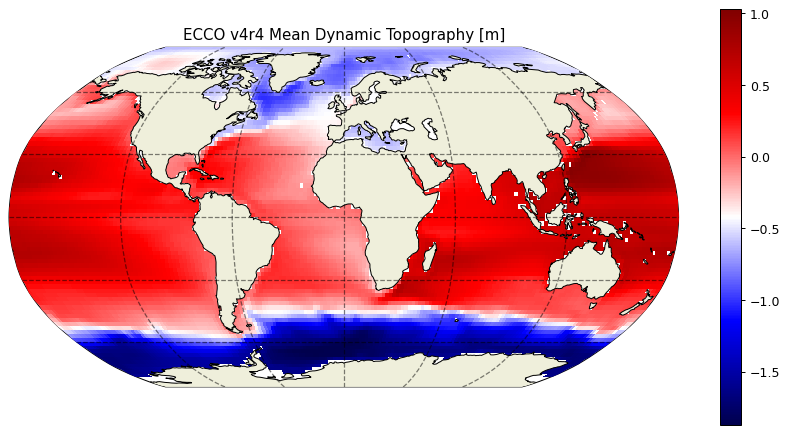

In [13]:
plt.figure(figsize=(12,6), dpi= 90)
MDT_no_spatial_mean = MDT_no_spatial_mean.where(ocean_mask[0,:] !=0)

# Plot projected data onto a latitude-longitude grid
# using the plot_proj_to_latlon_grid method of ecco dataset.
# This method plots the data in MDT_no_spatial_mean multiplied by ocean_mask at k=0.

ecco.plot_proj_to_latlon_grid(
    ecco_monthly_ds.XC,  # X coordinates for the plot
    ecco_monthly_ds.YC,  # Y coordinates for the plot
    MDT_no_spatial_mean * ocean_mask.isel(k=0),  # Data to be plotted at k=0, masked by ocean_mask
    user_lon_0=0,  # User-defined longitude
    plot_type='pcolormesh',  # Type of plot, in this case, pseudocolor mesh
    cmap='seismic',  # Color map for the plot
    show_colorbar=True,  # Display colorbar on the plot
    dx=2,  # Grid spacing in the x direction
    dy=2  # Grid spacing in the y direction
)

plt.title('ECCO v4r4 Mean Dynamic Topography [m]');